# New Clusters

In [12]:
#from data_loader import load_bolsa_m , load_bolsa
import os
import hdbscan
import itertools
import numpy as np
import pandas as pd
# import prettytable
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import mixture

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.metrics import silhouette_samples, silhouette_score, consensus_score
from sklearn.decomposition import RandomizedPCA
from sklearn.cross_validation import train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, estimate_bandwidth, MeanShift, KMeans, MiniBatchKMeans, SpectralClustering
from sklearn import metrics
# from sklearn.neighbors import kneighbors_graph

from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib nbagg
import warnings

In [124]:
pca_totales = pd.DataFrame()
datos = []
files = os.listdir("SojaData/")

for i in range(15):
    for j in range(12):
        pca_temp = np.array([])

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        pca_file = RandomizedPCA(n_components=3, random_state=10).fit_transform(df)
        pca_file = np.array(pca_file)
        
        n_cols = pca_file.shape[0] * pca_file.shape[1]
        pca_file = pca_file.reshape(1, n_cols)
        pca_temp = np.append(pca_temp, pca_file)
        datos = np.append(datos,pca_file)
        pca_totales = pca_totales.append(pd.DataFrame(pca_temp).T, ignore_index=True)

pca_totales.dropna(axis=0, how="all", inplace=True)
pca_totales.fillna(value=0,axis=0, inplace=True)
pca_totales[:3]

,0,1,2,3,4,5,6,7,8,9,...,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502
0,1.210584,0.003070,0.002220,1.208118,0.003027,0.001775,1.205593,0.002613,0.001122,1.204444,...,0.000329,-1.355995,-0.000088,0.000337,-1.358188,0.000006,0.000420,-1.360605,0.000275,0.000460
1,0.609058,0.001500,-0.000060,0.607829,0.001533,0.000197,0.606337,0.001441,0.000502,0.605258,...,0.001126,-0.638279,-0.000704,0.000917,-0.638991,-0.000801,0.000858,-0.639748,-0.000940,0.000883
2,0.776400,-0.000373,0.000843,0.775407,-0.000454,0.000783,0.774353,-0.000620,0.000696,0.773768,...,-0.000195,-0.807156,-0.001530,-0.000475,-0.807473,-0.001439,-0.000621,-0.808225,-0.001470,-0.000665


In [120]:
def plot_cls(name, data, labels):
    colores = ["r","g","b"]
    colores2 =[(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    col = [colores[x] for x in labels]
    col2 = [colores2[x] for x in labels]
    fig = plt.figure()
#     ax = fig.gca(projection="3d")
    ax = Axes3D(fig)
    for i, j in enumerate(np.unique(labels)):
        m = (j==labels)
        c = np.ma.array(col, mask=m)
        x = np.ma.array(d_plots.iloc[:,0], mask=m)
        y = np.ma.array(d_plots.iloc[:,1], mask=m)
        z = np.ma.array(d_plots.iloc[:,2], mask=m)
        ax.scatter(x, y, z, s=12, marker="o", c=c, alpha=1,label="Clase {0}({1} items)".format(i, np.sum(m)))
    
#     ax.scatter(data[0], data[2], zdir='y')
#     ax.scatter(data[1], data[2], zdir='x')
#     ax.scatter(data[0], data[1], zdir='z')
        
    plt.legend(loc=4)
    plt.title("Clusters por "+name)
    plt.show()

S_Score: 0.765883


<IPython.core.display.Javascript object>


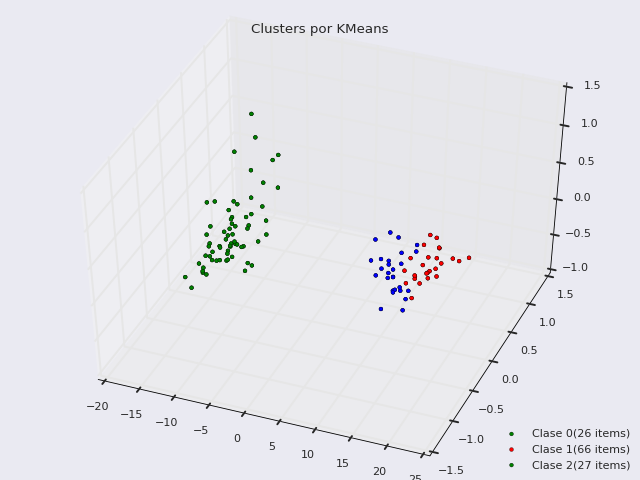

In [121]:
# df = pd.read_csv("SojaData/Prueba Claudio Bolsa 1-1.csv", header=2, index_col=0, skip_blank_lines=True)
pca = RandomizedPCA(n_components=3, random_state=10)
datos = pca.fit_transform(pca_totales)

km_ = KMeans(n_clusters=3, random_state=10)
km_.fit(datos)
km_cls = km_.predict(datos)

km_score = silhouette_score(datos, km_cls)
print("S_Score: %f"%km_score)

d_plots = pd.DataFrame(datos)

# d_plots["clase"] = km_cls
# col = [colores[x] for x in km_cls]
# d_plots.plot.scatter(x=0, y=1, c=col, s=20)
plt.show()
plot_cls("KMeans", d_plots, km_cls)

In [123]:
new_index = []
for i, j in itertools.product(range(12),range(10)):
    new_index.append('Bolsa {0}-{1}'.format(i+1,j+1))
new_index.remove('Bolsa 4-3')
d_plots = d_plots.reindex(index=new_index)
d_plots

/usr/lib/python3.5/site-packages/numpy/core/numeric.py:2515: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


,0,1,2
Bolsa 1-1,NaN,NaN,NaN
Bolsa 1-2,NaN,NaN,NaN
Bolsa 1-3,NaN,NaN,NaN
Bolsa 1-4,NaN,NaN,NaN
Bolsa 1-5,NaN,NaN,NaN
Bolsa 1-6,NaN,NaN,NaN
Bolsa 1-7,NaN,NaN,NaN
Bolsa 1-8,NaN,NaN,NaN
Bolsa 1-9,NaN,NaN,NaN
Bolsa 1-10,NaN,NaN,NaN
